In [113]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [114]:
avo = pd.read_csv('avocado.csv', index_col = 0)
avo = avo[avo.region == 'Chicago']
avo = avo[avo.type == 'organic']
avo

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.58,20995.37,1064.71,19320.66,0.0,610.00,610.00,0.00,0.0,organic,2015,Chicago
1,2015-12-20,1.58,22452.30,730.65,21574.99,0.0,146.66,143.33,3.33,0.0,organic,2015,Chicago
2,2015-12-13,1.59,24059.71,876.48,23109.90,0.0,73.33,73.33,0.00,0.0,organic,2015,Chicago
3,2015-12-06,1.59,27081.13,819.66,26104.80,0.0,156.67,156.67,0.00,0.0,organic,2015,Chicago
4,2015-11-29,1.59,22168.32,457.29,21677.70,0.0,33.33,33.33,0.00,0.0,organic,2015,Chicago
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-02-04,1.62,46956.84,313.29,32668.25,0.0,13975.30,13975.30,0.00,0.0,organic,2018,Chicago
8,2018-01-28,1.72,40770.94,215.40,31318.93,0.0,9236.61,9236.61,0.00,0.0,organic,2018,Chicago
9,2018-01-21,1.82,36688.67,83.93,28134.16,0.0,8470.58,8470.58,0.00,0.0,organic,2018,Chicago
10,2018-01-14,1.79,44955.89,133.39,31177.44,0.0,13645.06,13635.06,10.00,0.0,organic,2018,Chicago


In [125]:
avo.Date = pd.to_datetime(avo.Date)
avo = avo.sort_values('Date')
avo = avo.reset_index(drop=True)
price = avo[['Date','AveragePrice']]
price = price.set_index('Date')
price

,AveragePrice
Date,
2015-01-04,1.49
2015-01-11,1.79
2015-01-18,1.81
2015-01-25,1.83
2015-02-01,1.52
...,...
2018-02-25,1.68
2018-03-04,1.62
2018-03-11,1.66


In [126]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [127]:
df = pd.DataFrame()
df = df.append([(1,2,3)], ignore_index = True)
df = df.append([(1,2,3)], ignore_index = True)
df = df.append([(1,2,3)], ignore_index = True)
df.columns = ['param','param_seasonal', 'AIC']
df

,param,param_seasonal,AIC
0,1,2,3
1,1,2,3
2,1,2,3


In [128]:
df = pd.DataFrame()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(price,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

            combo = [(param,param_seasonal,results.aic)]
            df = df.append(combo)
            print(" ")
        except:
            continue
            
df.columns = ['param','param_seasonal', 'AIC']
df.reset_index()

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:668.7240239116677
 
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:463.5022292329602
 
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:78.49851064714419
 
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:17.059596397292353
 
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:78.94486329496527
 
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:9.99848216004112
 
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:58.31661932695564
 
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:19.06078133728567
 
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:455.55934223334214
 
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:296.87085005925184
 
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-12.72789428089445
 
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-71.48669226899497
 
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-13.175001800962498
 
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-81.56029062812718
 
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-35.93747234770432
 
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-61.67749636969364
 
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-175.4733246562902
 
ARIMA(0, 1, 0)x(0, 0,

,index,param,param_seasonal,AIC
0,0,"(0, 0, 0)","(0, 0, 0, 12)",668.724024
1,0,"(0, 0, 0)","(0, 0, 1, 12)",463.502229
2,0,"(0, 0, 0)","(0, 1, 0, 12)",78.498511
3,0,"(0, 0, 0)","(0, 1, 1, 12)",17.059596
4,0,"(0, 0, 0)","(1, 0, 0, 12)",78.944863
...,...,...,...,...
59,0,"(1, 1, 1)","(0, 1, 1, 12)",-127.017274
60,0,"(1, 1, 1)","(1, 0, 0, 12)",-166.042824
61,0,"(1, 1, 1)","(1, 0, 1, 12)",-166.155370
62,0,"(1, 1, 1)","(1, 1, 0, 12)",-95.344628


In [129]:
#Print out the model with leaset AIC
df[df.AIC == df.AIC.min()]

,param,param_seasonal,AIC
0,"(1, 1, 1)","(0, 0, 0, 12)",-180.510182


### The above output suggests that SARIMAX(1, 1, 1)x(0, 0, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

In [130]:
mod = sm.tsa.statespace.SARIMAX(price,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7861      0.051     15.531      0.000       0.687       0.885
ma.L1         -1.0147      0.021    -47.464      0.000      -1.057      -0.973
sigma2         0.0182      0.002     11.300      0.000       0.015       0.021


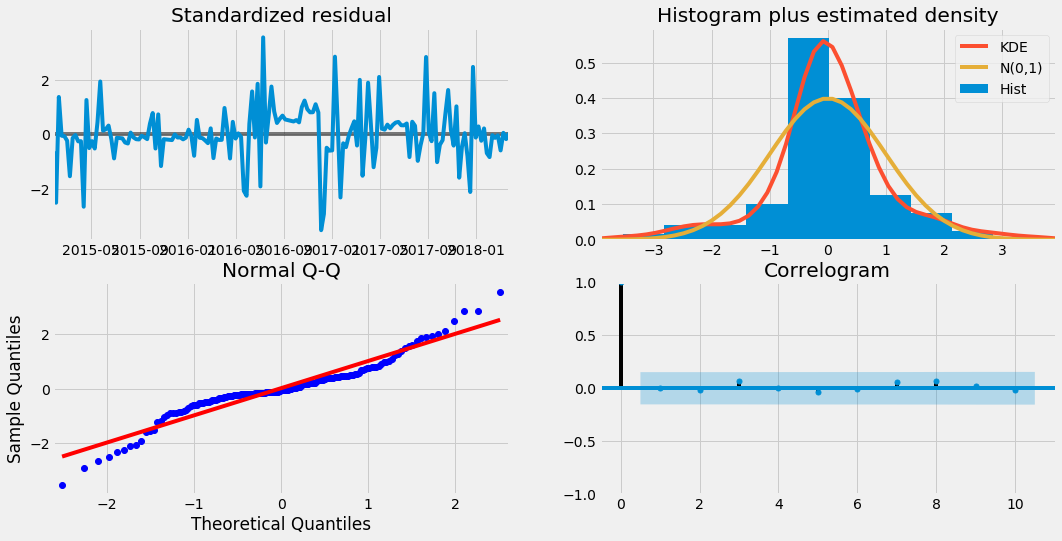

In [133]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [208]:
avo2018 = avo[avo.year == 2018]
avo2018

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
157,2018-01-07,1.83,41573.25,118.84,29600.36,0.0,11854.05,11850.72,3.33,0.0,organic,2018,Chicago
158,2018-01-14,1.79,44955.89,133.39,31177.44,0.0,13645.06,13635.06,10.00,0.0,organic,2018,Chicago
159,2018-01-21,1.82,36688.67,83.93,28134.16,0.0,8470.58,8470.58,0.00,0.0,organic,2018,Chicago
160,2018-01-28,1.72,40770.94,215.40,31318.93,0.0,9236.61,9236.61,0.00,0.0,organic,2018,Chicago
161,2018-02-04,1.62,46956.84,313.29,32668.25,0.0,13975.30,13975.30,0.00,0.0,organic,2018,Chicago
162,2018-02-11,1.65,38202.17,409.68,26524.51,0.0,11267.98,11261.31,6.67,0.0,organic,2018,Chicago
163,2018-02-18,1.66,33678.58,259.18,24314.04,0.0,9105.36,9095.36,10.00,0.0,organic,2018,Chicago
164,2018-02-25,1.68,36432.65,246.73,29263.75,0.0,6922.17,6908.84,13.33,0.0,organic,2018,Chicago
165,2018-03-04,1.62,46026.58,1107.05,35255.03,0.0,9664.50,9654.50,10.00,0.0,organic,2018,Chicago
166,2018-03-11,1.66,41969.83,583.18,32382.95,0.0,9003.70,8990.36,13.34,0.0,organic,2018,Chicago


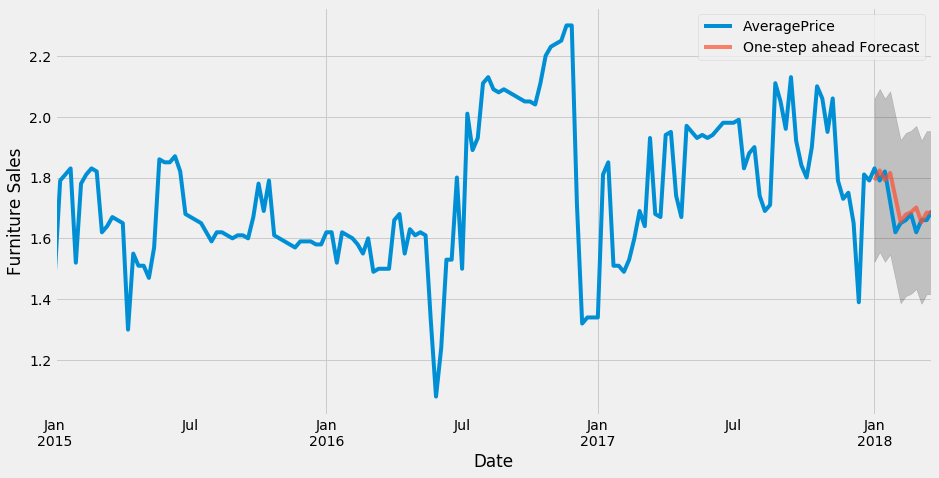

In [225]:
pred = results.get_prediction(start=pd.to_datetime(avo2018.iloc[0,:][0]), dynamic=False)
pred_ci = pred.conf_int()
ax = price.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [231]:
pred.predicted_mean
print(price.index[157:,])
price2018 = price.iloc[157:,]
price2018

DatetimeIndex(['2018-01-07', '2018-01-14', '2018-01-21', '2018-01-28',
               '2018-02-04', '2018-02-11', '2018-02-18', '2018-02-25',
               '2018-03-04', '2018-03-11', '2018-03-18', '2018-03-25'],
              dtype='datetime64[ns]', name='Date', freq=None)


,AveragePrice
Date,
2018-01-07,1.83
2018-01-14,1.79
2018-01-21,1.82
2018-01-28,1.72
2018-02-04,1.62
2018-02-11,1.65
2018-02-18,1.66
2018-02-25,1.68
2018-03-04,1.62


In [237]:
price_forecasted = pred.predicted_mean
price_truth = price2018.AveragePrice
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(mse))

print('The Root Mean Squared Error of our forecasts is {}'.format(np.sqrt(mse), 2))

The Mean Squared Error of our forecasts is 0.0027878178945144895
The Root Mean Squared Error of our forecasts is 0.05279979066733589
